In [119]:
import pandas as pd
import numpy as np
import sklearn.decomposition
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import emcee
import tissue_enrichment_analysis as tea
import matplotlib.patheffects as path_effects
import morgan as morgan

import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

import networkx as nx
import matplotlib as mpl


# Display graphics in this notebook
bokeh.io.output_notebook()


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
# sns.set_style('darkgrid', rc=rc)
sns.set_style("dark")

import genpy

ft = 35 #title fontsize

Loading BokehJS ...

In [464]:
phenotype_df = pd.read_csv('../input/dictionaries/phenotype_dictionary.csv')
tissue_df = tea.fetch_dictionary()
tf_df = pd.read_csv('../input/tf_list.csv')

# Mutants:

I have been given 4 single mutants and 2 double mutants. This is a blind study, so I don't know the identities of the mutants. 

Single mutants:

b, c, d, e

Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

In [3]:
# Specify the genotypes
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'
thomas.add_betas(sleuth_loc, 'betas.csv', combs)

thomas.filter_data(0, 0.1)

Number of na genes: 1370


# PCA Analysis of TPM Data

PCA analysis of TPM data should hopefully reveal some structure and clustering in this dataset. 

First, I want to know how many PCs explain >90% of the data, then build a PCA object with that
many dimensions which I will use for agglomerative clustering. 

In [190]:
# PCA
#exclude g
pca_matrix = genpy.make_matrix(thomas.tpm, thomas.genmap, 'project_name', 'tpm')
sklearn_pca, n = genpy.pca(pca_matrix)

The first 2 principal components explain >=90% of the data


In [191]:
# keep only the first principal components that explain 90% of the data
if n < 3:
    n = 3

df_nD = genpy.tidy_pca(pca_matrix, n)

# add a sample and genotype column
df_nD['samples'] = thomas.genmap.project_name.unique()
l = lambda x: thomas.genmap[thomas.genmap.project_name == x].genotype.values[0]
df_nD['genotypes'] = df_nD.samples.apply(l)
df_nD.head()

,PCA1,PCA2,PCA3,samples,genotypes
0,-3074.738613,7600.523437,284.786479,Project_17434_indexN704-N517,wt
1,-5417.810850,-11536.433530,2140.852741,Project_17441_indexN704-N508,a
2,-5548.800304,3477.094911,-6528.906595,Project_17448_indexN705-N507,d
3,-2251.384720,7684.334764,-469.041964,Project_17435_indexN704-N502,wt
4,-3354.903582,-10095.999283,1640.623328,Project_17442_indexN705-N517,a


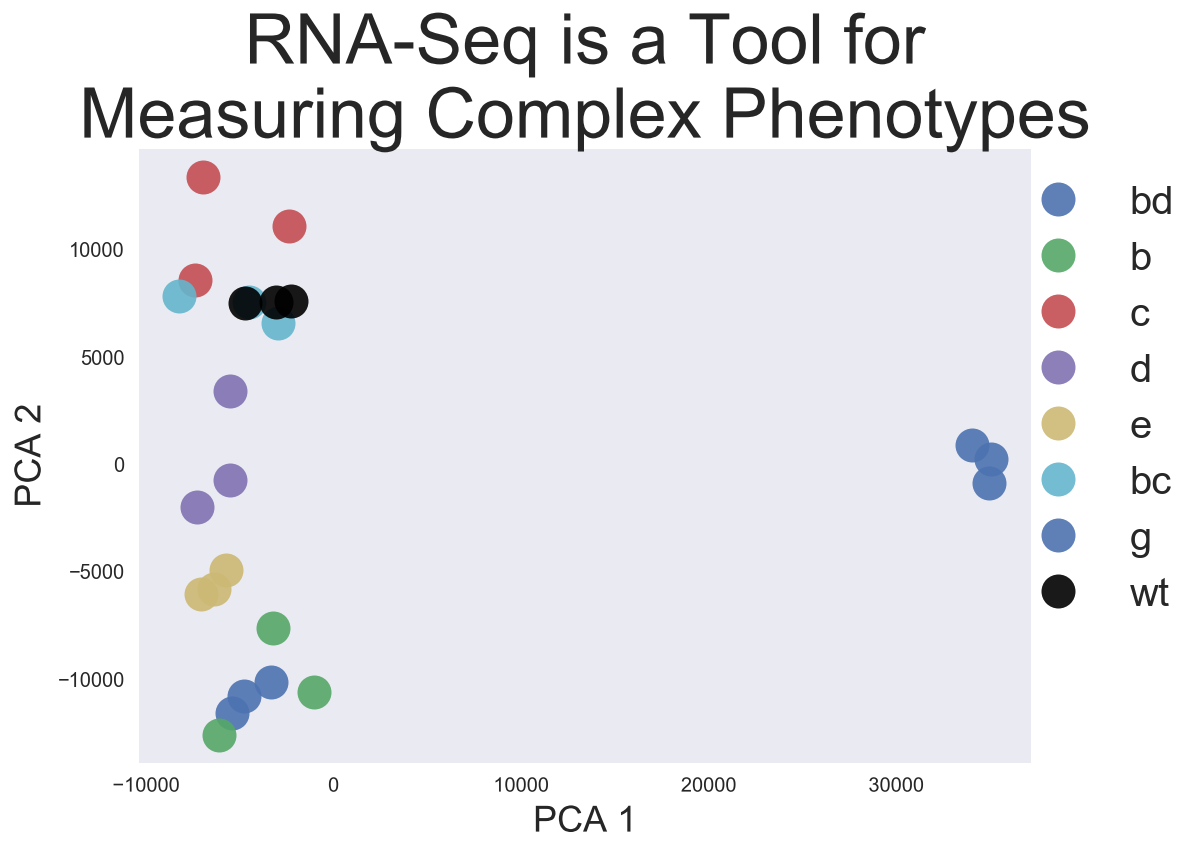

In [192]:
def plot_2d_pca(df_pca, group_col, special_key, double_mutant_hash= {},save=''):
    """
    Very basic wrapper around plt.plot to plot pca results after using tidy_pca.
    
    df_pca - df output by tidy_pca
    group_col - column in df_pca to group by
    special_key - if there's a particular group to color in black, use special_key
                  to identify it
    
    returns:
    a matplotlib object
    """
    # plot first 2d components! 
    for key, group in df_nD.groupby(group_col):
        if key == special_key:
            plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.9, label=key, ms=17)
        else:
            if key not in double_mutant_hash.keys():
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=key, ms=17)
            else:
                plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=double_mutant_hash[key], ms=17)

    # Tidy up plot
    plt.legend(bbox_to_anchor=(1.2, 1), fontsize=20).set_path_effects([path_effects.Normal()])
    plt.margins(0.05)
    plt.xlabel('PCA 1').set_path_effects([path_effects.Normal()])
    plt.ylabel('PCA 2').set_path_effects([path_effects.Normal()])
    if save:
        plt.savefig(save)
    
    
plot_2d_pca(df_nD, 'genotypes', 'wt', double_mutants)

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()[::1]):
    ax.get_xticklabels()[::1][i] = ax.get_xticklabels()[::1][i].set_path_effects([path_effects.Normal()])

    
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=10**4) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5*10**3) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.title('RNA-Seq is a Tool for\nMeasuring Complex Phenotypes', fontsize=ft).set_path_effects([path_effects.Normal()])
plt.savefig('../output/tpm_pca.pdf', bbox_inches='tight')


Clearly, we can see a few things:

b, e and d all cluster far away from the WT, primarily along PCA1. 

The double mutant f has a mean PCA location very close to b. 

Mathematically:
$$
b^-d^- \sim b^-
$$

The mutant c has a centroid relatively close to the WT. 

The double mutant f is almost identical to the WT:
$$
b^-c^- \sim WT
$$

However, we are only looking at the first 2 dimensions of the PCA, and we know that 90% of the variance is contained in the first 4. So we can perform agglomerative clustering to make sure these observations are correct. 

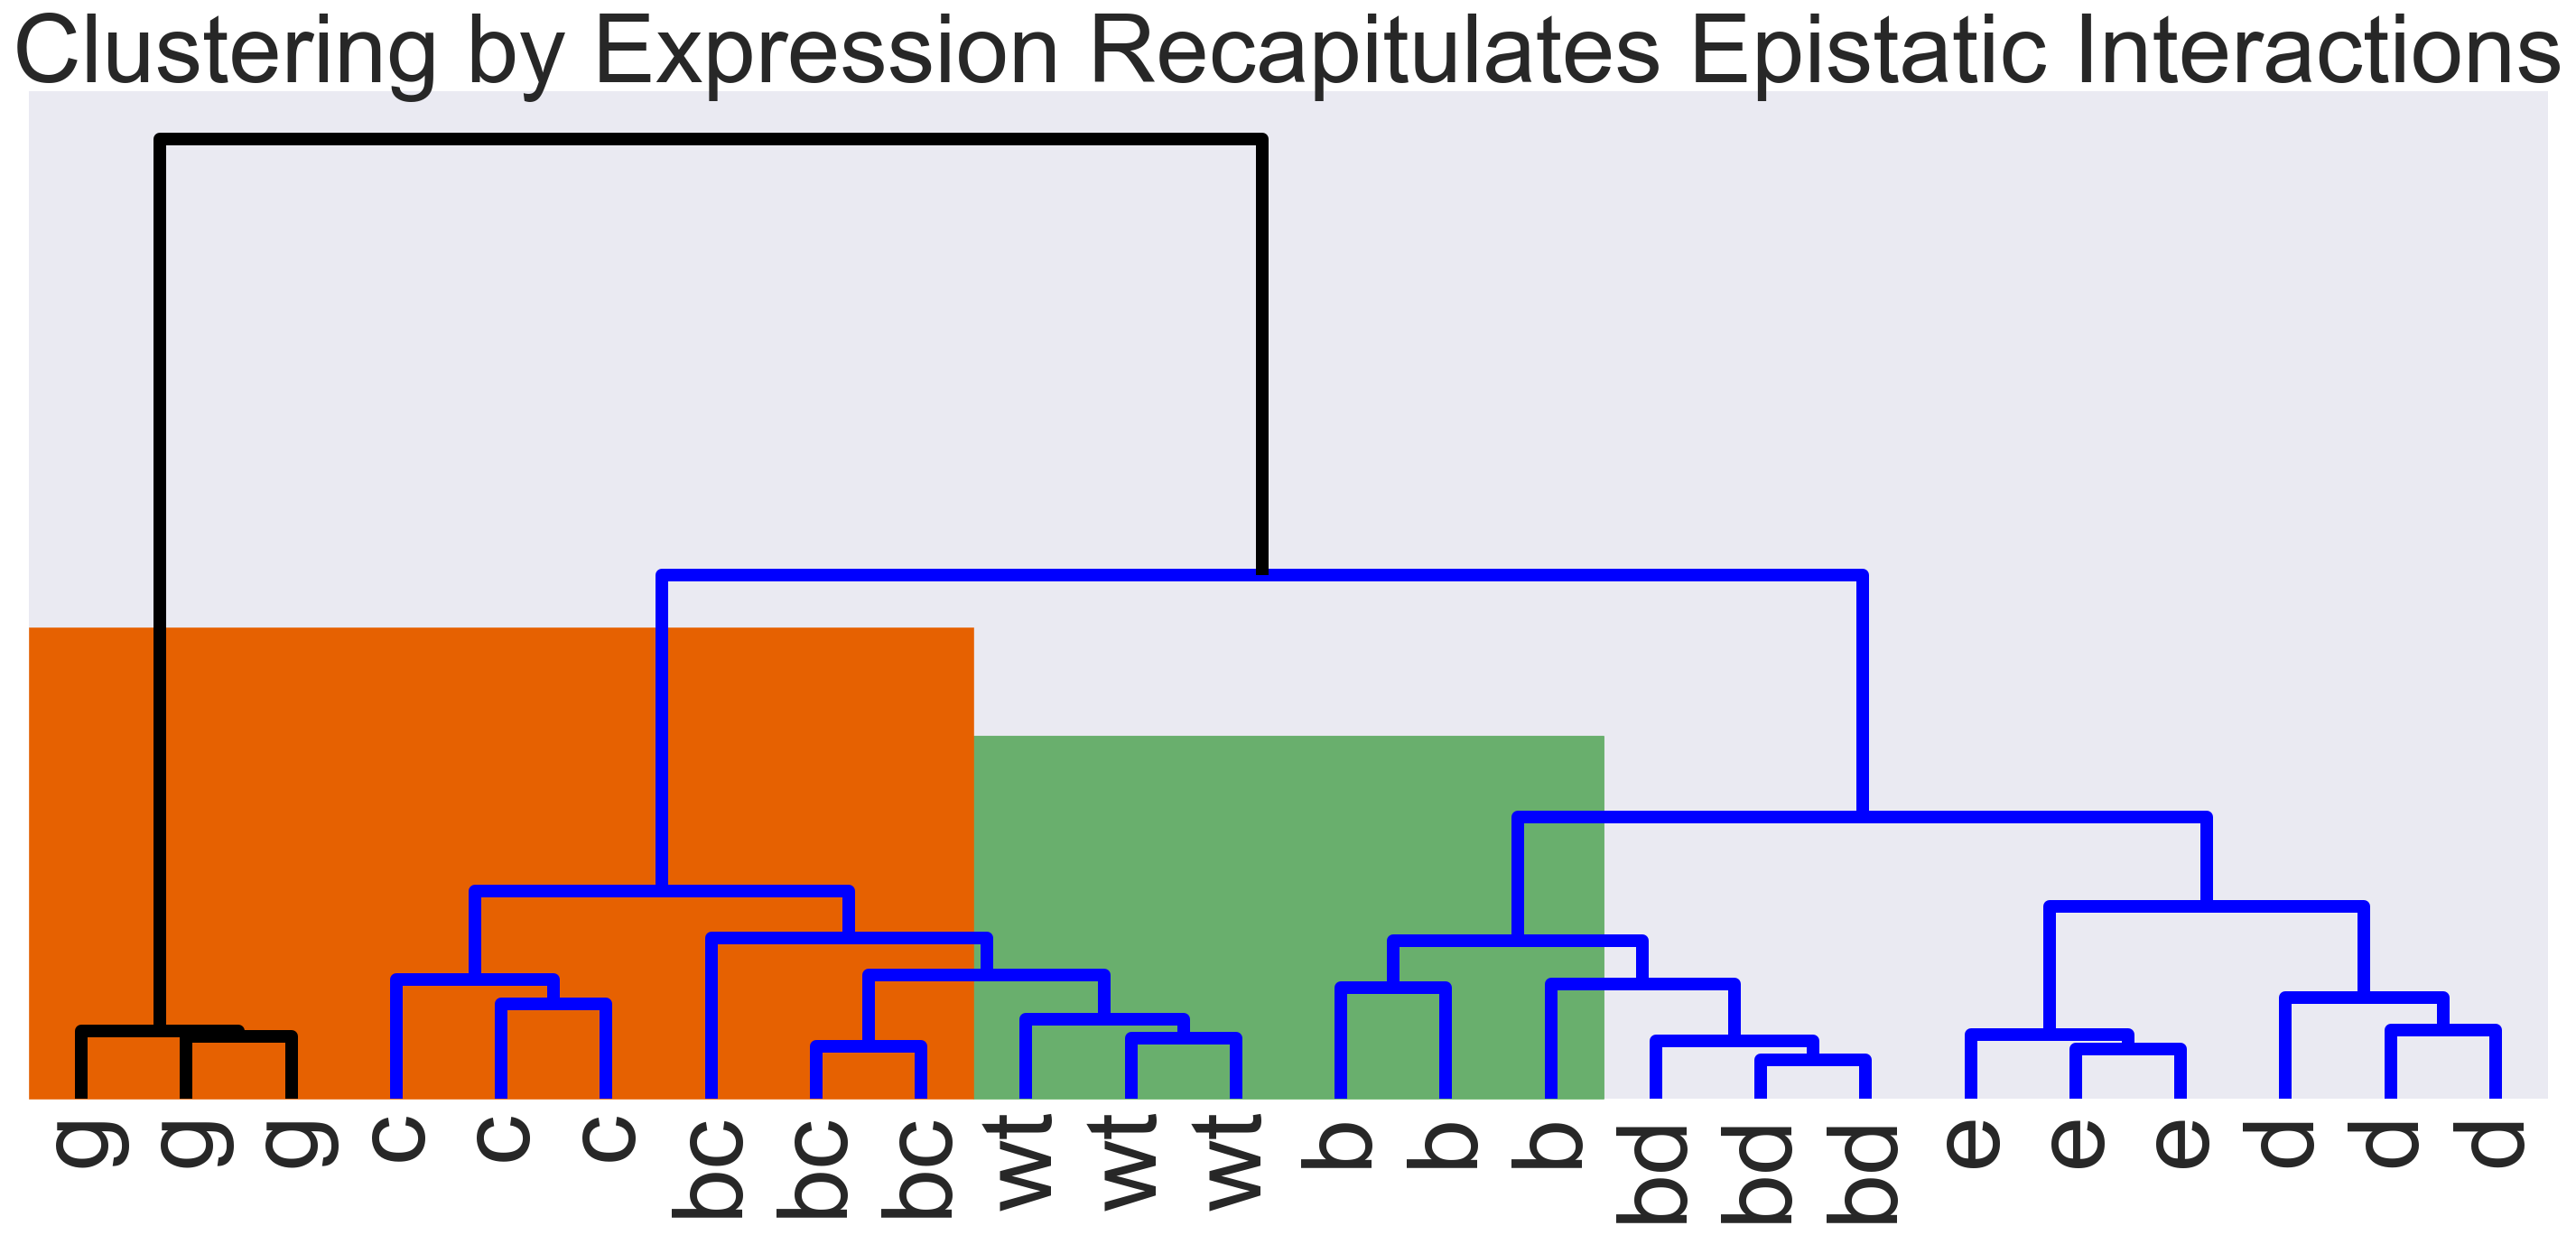

In [193]:
model = hierarchy.linkage(sklearn_pca.transform(pca_matrix), 'ward')
plt.figure(figsize=(25, 10))

labels = df_nD.genotypes.values

for i, label in enumerate(labels):
    if label in double_mutants:
        labels[i] = double_mutants[label]

# ax, fig = plt.subplots()
plt.rcParams['lines.linewidth'] = 7

hierarchy.set_link_color_palette(['k', 'b'])
# fig, ax = plt.subplots()

hierarchy.dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=df_nD.genotypes.values,
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    above_threshold_color='k'
)

ax = plt.gca()
height = ax.get_ylim()[1]*.36
ax.fill_between([90, 150], 0.0, height, 
                    where=[1,1], color='g', alpha=0.55, zorder=0)
ax.fill_between([0, 90], 0.0, height*1.3, 
                    where=[1,1], color='#e66101', alpha=1, zorder=0)

plt.xticks(fontsize=55)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.yticks(fontsize=30)
plt.title('Clustering by Expression Recapitulates Epistatic Interactions', fontsize=ft*1.5)
# plt.xlabel('sample index', fontsize=40)
# plt.ylabel('distance', fontsize=40)
plt.savefig('../output/tpm_dendrogram.pdf', bbox_inches='tight')

In fact, it does appear that 
$$
f \sim WT
$$

$$
a \sim b
$$

$$
|c - WT| = min~|g - WT|~ \mathrm{for }~~ g~\in~[b, c, d, e]
$$

Where this last expression means: C is closest to the WT out of [b, c, d, e]

# PCA Based On Stat. Sig. Gene Changes Is Not Helpful

Before we did PCA based on total TPM counts for every gene. In this next section, we will see that clustering genotypes by statistically significant gene changes is not helpful.

The reason is simple. PCA is a variance maximization tool. Feeding in the calculated log linear regression slopes from sleuth (trimmed so that all the NAs are gone) is (anthropomorphizing) like telling the computer what genes to use to identify each genotype. Feeding in the information about what genes really change will make it easier to find just a very few dimensions that allow us to separate the points easily. So, what we will see is that in general feeding in the log linear regressions will  
* Allow us to find PCA components that better separate each genotype
* Allow us to find less PCA components that cumulatively explain the variance in the data
* As a result of this, more subtle effects can be observed, but tight relationships between genotypes become less obvious (subtle differences play a larger role)

At any rate, it's a good idea to filter the data by TPM, 'fold change' and qvalues, so we will go ahead and do this now. 

In [ ]:
# # Figure out what genes are in 10% or above expression in TPM for all samples. Delete anything below that...
thomas.filter_data(0, 0.1)

# Filtering Does Not Seriously Alter Differentially Expressed Genes

In [432]:
q = 0.1
for key, df in thomas.beta.items():
    sig_genes = len(df[df.qval < q])
    mc = np.exp(df[df.qval < q].b.abs().max())
    print('{0} has {1} diff. exp. genes before filtering with mean fold change {2:.2g}'.format(key, sig_genes, mc))
    df = thomas.beta_filtered[key]
    sig_genes = len(df[df.qval < q])
    print('{0} has {1} diff. exp. genes after filtering'.format(key, sig_genes))
    print('-----------\n')


f has 369 diff. exp. genes before filtering with mean fold change 1.6e+03
f has 363 diff. exp. genes after filtering
-----------

d has 990 diff. exp. genes before filtering with mean fold change 1.9e+03
d has 969 diff. exp. genes after filtering
-----------

a has 2966 diff. exp. genes before filtering with mean fold change 4e+02
a has 2789 diff. exp. genes after filtering
-----------

c has 964 diff. exp. genes before filtering with mean fold change 3.2e+02
c has 931 diff. exp. genes after filtering
-----------

b has 1856 diff. exp. genes before filtering with mean fold change 7.7e+02
b has 1780 diff. exp. genes after filtering
-----------

e has 2505 diff. exp. genes before filtering with mean fold change 6e+02
e has 2424 diff. exp. genes after filtering
-----------

g has 1648 diff. exp. genes before filtering with mean fold change 3.3e+04
g has 1605 diff. exp. genes after filtering
-----------



# PCA with 'fold changes':

This will separate the genotypes out well, but it's not going to be as informative -- the information has been processed relative to wildtype, so the question this asks is: How different are the genotypes? Since the data has been processed, it's already in an ideal format to separate the genotypes (i.e., diff. expressed genes). 

In [189]:
# PCA
pca_matrix = genpy.make_matrix(thomas.beta_filtered, thomas.genmap[(thomas.genmap.genotype != 'wt') ],
                               'genotype', 'qval')
sklearn_pca, n = genpy.pca(pca_matrix)
# # keep only the first principal components that explain 90% of the data
df_nD = genpy.tidy_pca(pca_matrix, n)

# # add a sample and genotype column
df_nD['genotypes'] = thomas.genmap[(thomas.genmap.genotype != 'wt') ].genotype.unique()
# df_nD['genotypes'] = thomas.single_mutants
plot_2d_pca(df_nD, 'genotypes', 'wt', save='../output/preliminary_pca.pdf')

The first 3 principal components explain >=90% of the data


NameError: name 'plot_2d_pca' is not defined

# Nomenclature



# Single Mutant Analysis

There seem to be two obvious ways of analyzing this kind of data. By far the simplest method is using Spearman R analysis. 

## Correlational Transcriptome Analysis


## Bayesian Probability of Interaction


## Other kinds of activation



# Evaluating the Spearman R method versus Bayesian Regression

400


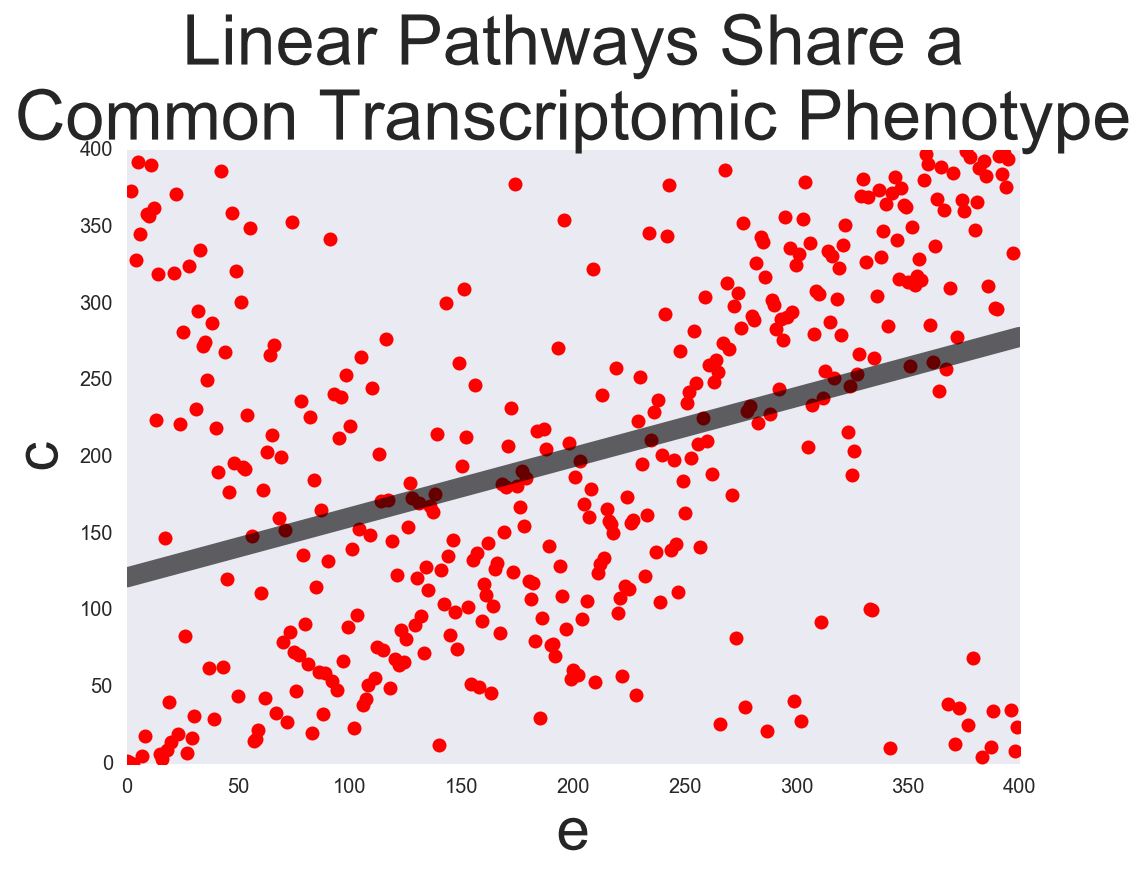

In [79]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

# As an example, let me show you what a good spearman correlation looks like:
genes = 'target_id'

letters = ['e', 'c']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

slope, intercept, r_value, p_value, std_err = stats.linregress(ovx.r,ovy.r)


print(len(ovx))
X = np.linspace(0, len(ovx.r))
Y = slope*X + intercept

# print('{0:.2g}'.format(r))
plt.plot(ovx.r, ovy.r, 'ro', alpha=1, label='Overlapped Diff. Exp. Genes')

plt.plot(X, Y, 'k-', alpha=0.6, lw=10, label= 'Best Fit')

# plt.xlim(-5, 500)
# plt.ylim(-5, 500)

plt.title('Linear Pathways Share a\nCommon Transcriptomic Phenotype', fontsize=ft).\
            set_path_effects([path_effects.Normal()])
plt.xlabel(letters[0], fontsize=30).set_path_effects([path_effects.Normal()])
plt.ylabel(letters[1], fontsize=30).set_path_effects([path_effects.Normal()])

# plt.xticks([0, 250, 500], fontsize=15)
# plt.yticks([0, 250, 500], fontsize=15)

plt.savefig('../output/spearmanr_b_and_c.pdf')

Spearman R predicts a trend, but the strength is dubious at best. Moreover, there's at least one VERY clear trend line, and the slope is NOT what Spearman predicts. Let's see if we can't do better. 

In [67]:
import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano

def robust_regress(data):
    """A robust regression using a StudentT distribution instead of a Gaussian model."""
    with pm.Model() as model_robust:
        family = pm.glm.families.StudentT()
        pm.glm.glm('y ~ x', data, family=family)
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace_robust = pm.sample(2000, step, progressbar=True)
        return trace_robust

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 secComplex Regulation at Work


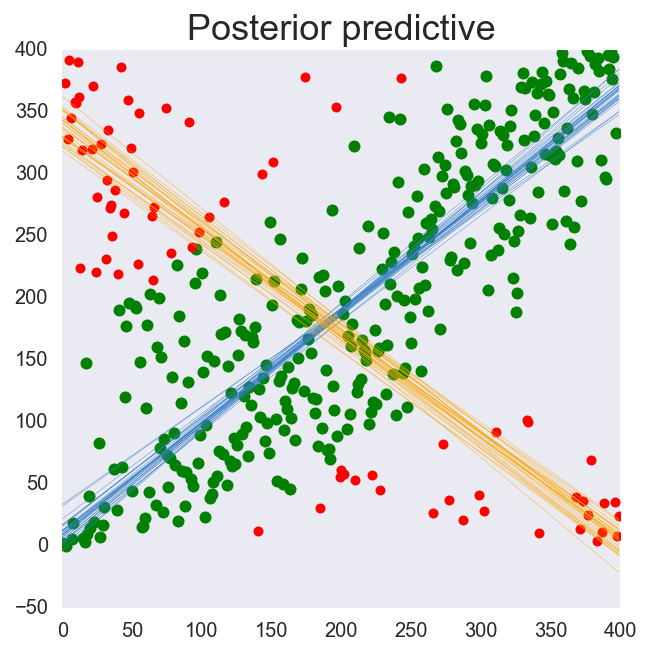

In [72]:
# Set up MCMC parameters
data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

plt.plot(ovx.r, yri, 'go', ms = 7)
plt.plot(ovx.r, yro, 'ro', ms = 5)
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#FFA500')
plt.xlim(0, len(ovx))
# plt.legend()

if np.abs(trace_robust.x.mean()) > 0.6 and np.abs(trace_robust2.x.mean()) > 0.6:
    t1 = trace_robust.x.mean()/np.abs(trace_robust.x.mean())
    t2 = trace_robust2.x.mean()/np.abs(trace_robust2.x.mean())
    if t1 == -t2:
        print('Complex Regulation at Work')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16bb07ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x16c136390>]], dtype=object)

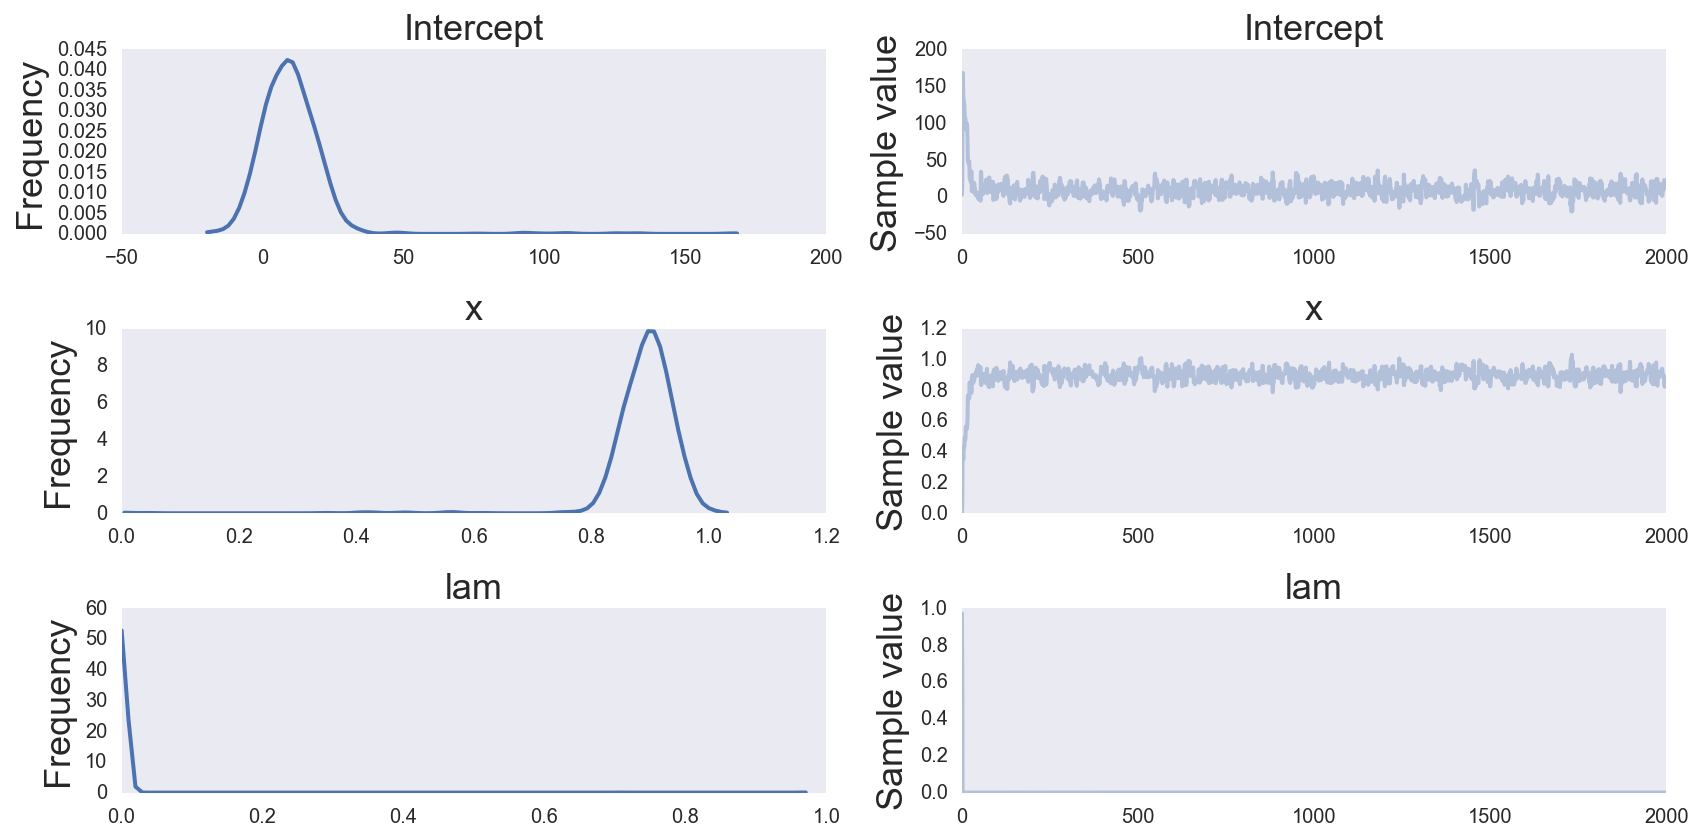

In [73]:
pm.traceplot(trace_robust)

# Spearman R Analysis

-0.369938689964 1.0


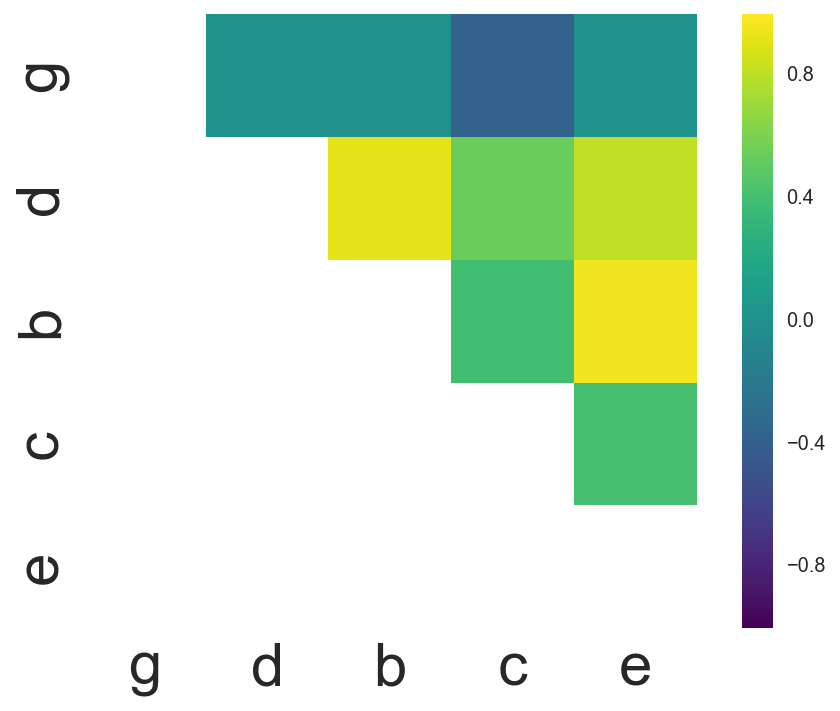

In [80]:
# Perform Correlation Analysis
def tri_plot(matrix, xlabels, ylabels=[]):
    vmin= matrix.min().min()
    vmax=np.max(matrix).max()
    print(vmin, vmax)
    if len(ylabels) == 0:
        ylabels = xlabels
        
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(matrix, xticklabels=xlabels, yticklabels=ylabels, cmap='viridis',
                         mask=mask, square=True, vmin=vmin, vmax=vmax)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)

thomas.spearman_analysis()

tri_plot(thomas.rho, thomas.single_mutants)
# plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)
# plt.savefig('../output/spearmr_matrix_single_mutants.pdf', bbox_inches='tight')

From the above, we can draw the following arrows:


Interaction | $\rho$ |
----------- | ------- |
b -gp- d| 0.92
b -gp- e| 0.96
d -gp- e| 0.81
d -g- c| 0.53
b -g- c| 0.38
e -g- c| 0.41

Due to the weakness of the spearman correlation of b, d, e with c, we can't draw any conclusions about its sign


# Hypergeometric Analysis:

8.71034906824e-15 1.0
              g         d         b             c         e
g  1.000000e+00  0.196915  0.004801  8.710349e-15  0.000297
d  1.969147e-01  1.000000  1.000000  1.000000e+00  1.000000
b  4.801400e-03  1.000000  1.000000  1.000000e+00  1.000000
c  8.710349e-15  1.000000  1.000000  1.000000e+00  1.000000
e  2.967629e-04  1.000000  1.000000  1.000000e+00  1.000000


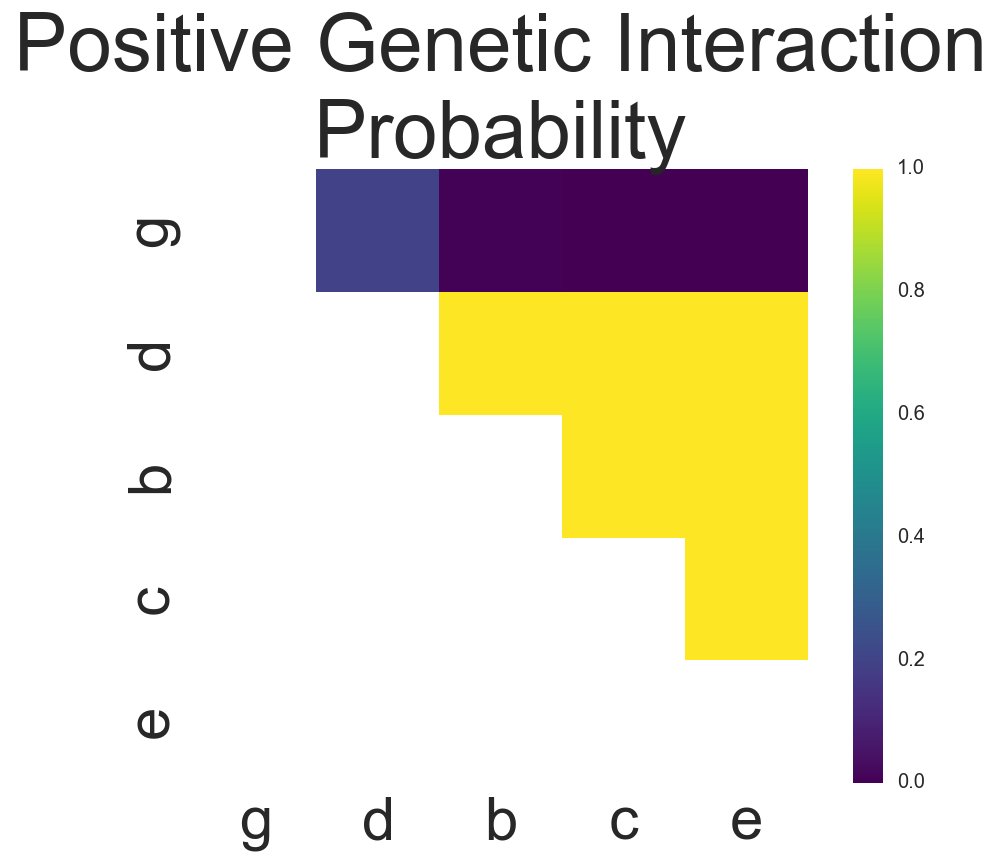

In [51]:
thomas.probabilistic_interaction_analysis()

tri_plot(thomas.prob_plus, thomas.single_mutants)
print(thomas.prob_plus)
plt.title('Positive Genetic Interaction\nProbability', fontsize=40)
plt.savefig('../output/probability_of_interaction_single_mutants.pdf', bbox_inches='tight')

2.372560984e-235 0.905778313244


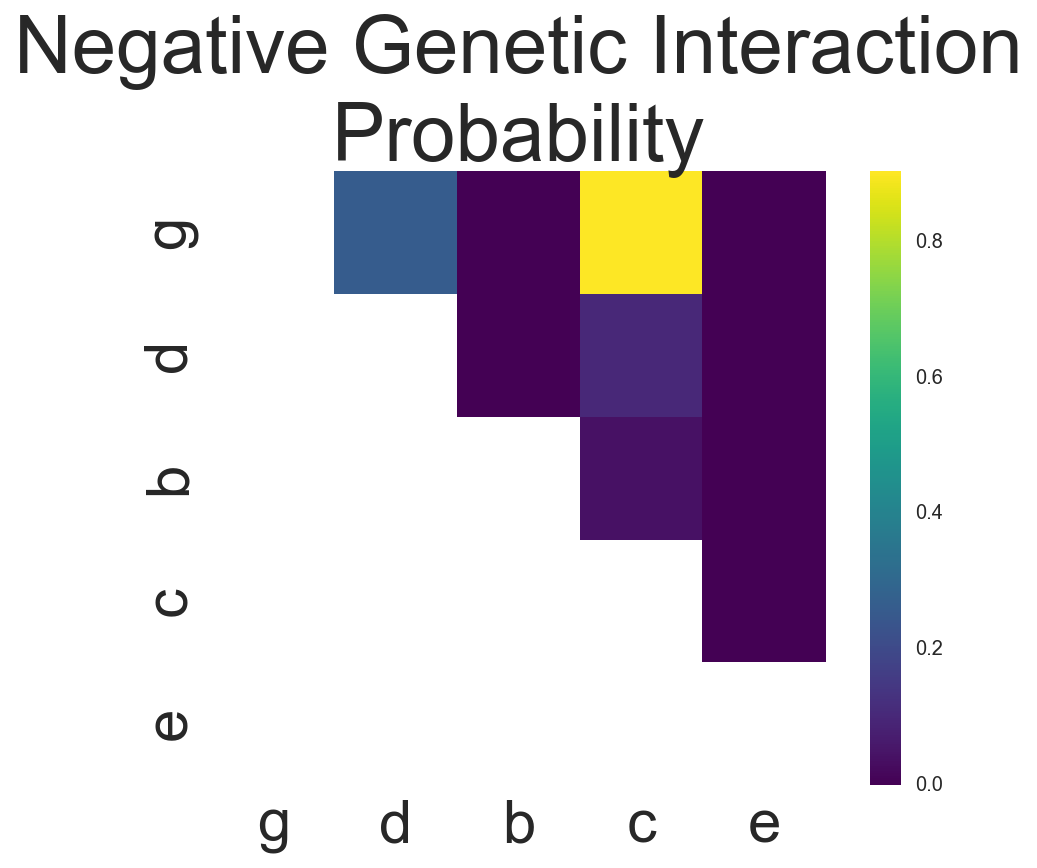

In [53]:
tri_plot(thomas.prob_minus, thomas.single_mutants)
plt.title('Negative Genetic Interaction\nProbability', fontsize=40)
plt.savefig('../output/probability_of_inhibition_single_mutants.pdf', bbox_inches='tight')

# thomas.prob_minus[thomas.prob_minus > 10**-4]

# Analysis Using Robust Spearman Regression

What I do here is try to identify trends. Namely, for two genotypes X and Y, I fit a line using a Bayesian robust regression (see methods) thru the rank-ordered regression coefficients that are statistically significantly different from 0 and that are present in both X and Y. Next, I use this Bayesian framework to identify any and all outliers to the regression. 

In order to test for alternative modes of interaction in this dataset, I take the outliers and I run the same regression again *on the outliers*. If this second interaction has an opposite sign to the first, then we predict that there are two modes of interaction, subject to the following caveats:

 * Both the primary and secondary regressions yield large slopes values (>0.7)
 * The first regression results in many outliers (at least 10% of all the values)

Finally, because of the approach I used, I can also predict which genes are under what mode of regulation. Super cool!

In [56]:
thomas.robust_regression_primary()
thomas.robust_regression_secondary()


starting comparison of g, d
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec
starting comparison of g, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.1 sec
starting comparison of g, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
starting comparison of g, e
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.3 sec
starting comparison of d, b
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec
starting comparison of d, c
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-------------

-0.861148972202 0.99536957508


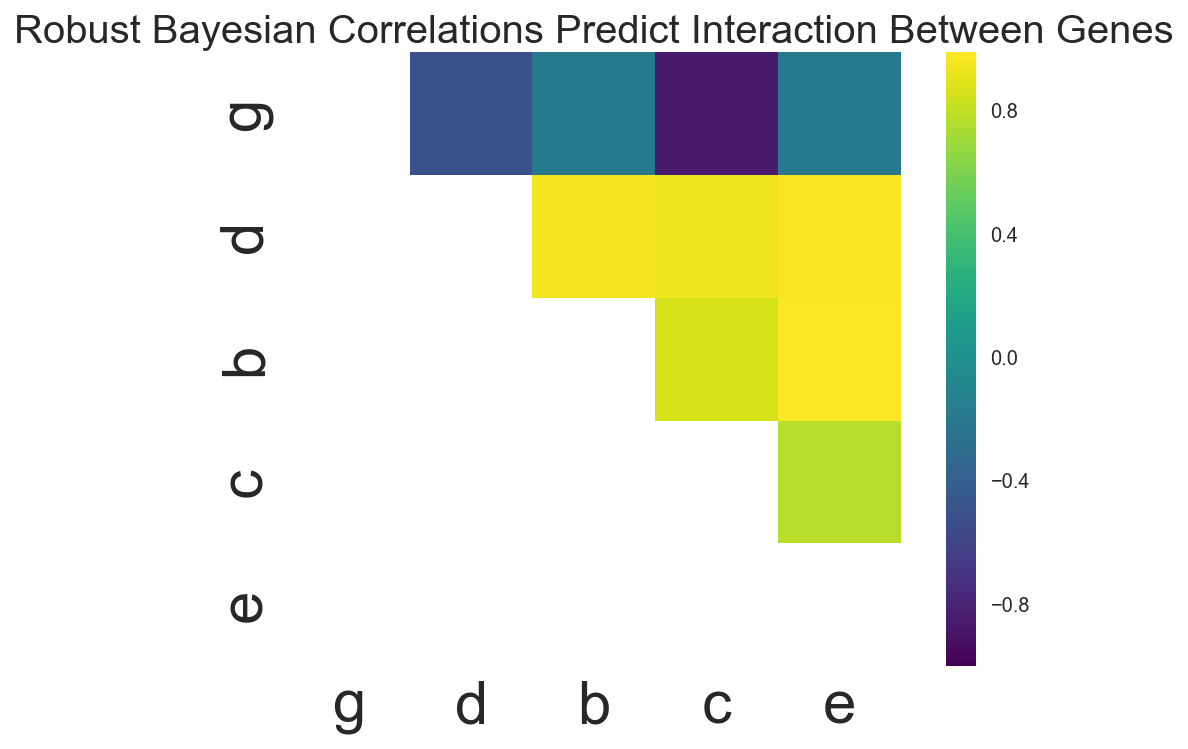

In [57]:
tri_plot(thomas.robust_slope, thomas.single_mutants)
plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)
# plt.savefig('../output/spearmr_matrix_single_mutants.pdf', bbox_inches='tight')

-0.984025304591 0.80926078223


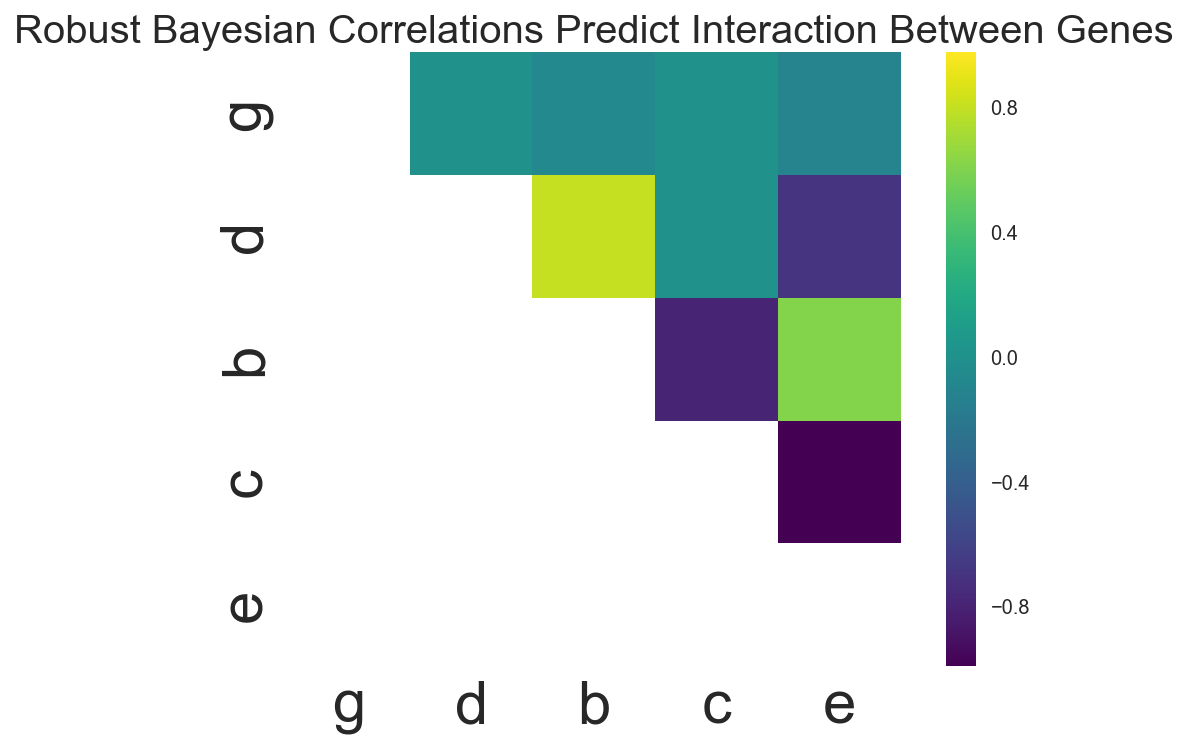

In [58]:
tri_plot(thomas.secondary_slope, thomas.single_mutants)
plt.title('Robust Bayesian Correlations Predict Interaction Between Genes', fontsize=20)


Another way to plot the results from the regression above is to make scatterplots. For that, it's best to work with tidy dataframes. 

In [345]:
def tidy_df(df, corr='corr'):
    """
    A function that returns a tidied up dataframe.
    
    Dataframe provided must be the result of morgan.robust_regression()
    or morgan.robust_regression_secondary()
    
    df - dataframe to tidy up
    corr - please specify whether this dataframe is from morgan.robust_regression (write 'corr')
    or from morgan.robust_regression_secondary() (write 'outlier')
    
    outputs:
    df - a tidied dataframe with columns 'corr_wit', 'variable', 'fraction' and 'pair'
    """
    df = df.copy()
    df['corr_with'] = thomas.single_mutants
    df = pd.melt(df, id_vars='corr_with')
    df = df[df.corr_with != df.variable]

    def add_fraction_overlap(x):
        if (x.corr_with, x.variable) in thomas.correlated_genes.keys():
            dd = thomas.correlated_genes[(x.corr_with, x.variable)]
            corr = len(dd['corr'])
            total = len(thomas.beta_filtered['a'])  # TODO: make arbitrary variable
            return corr/total
        else:
            return np.nan

    def add_fraction_outliers(x, fraction='corr'):
        if (x.corr_with, x.variable) in thomas.correlated_genes.keys():
            dd = thomas.correlated_genes[(x.corr_with, x.variable)]
            outliers = len(dd['outliers'])
            corr = len(dd['corr'])
            total = outliers + corr
            if fraction == 'corr':
                return corr/total
            else:
                return outliers/total
        else:
            return np.nan

    df['fraction_overlap'] = df.apply(add_fraction_overlap, axis=1)
    df['fraction_outliers'] = df.apply(add_fraction_outliers, args=(corr,), axis=1)
    df['pair'] =  df.variable + df.corr_with
    return df

d_pos = tidy_df(thomas.robust_slope)
d_pos['regression'] = 'primary'
d_minus = tidy_df(thomas.secondary_slope, corr='outliers')
d_minus['regression'] = 'secondary'

In [346]:
frames = [d_pos, d_minus]
d = pd.concat(frames)

def different(x):
    if x.regression == 'primary':
        return np.nan
    p = x.pair
    primary = d[(d.pair == p) & (d.regression == 'primary')].value.values[0]
    secondary = x.value
    
    if primary == 0 or secondary == 0:
        return 0
    elif (primary > 0 and secondary > 0) or (primary < 0 and secondary < 0):
        return -1
    else:
        return 1

d['different'] = d.apply(different, axis=1)

In [347]:
def calculate_overlap(x):
    if (x.variable, x.corr_with) in thomas.overlap_ids_plus.keys():
        op = len(thomas.overlap_ids_plus[(x.variable, x.corr_with)])
    else:
        op = 0
    if (x.variable, x.corr_with) in thomas.overlap_ids_minus.keys():
        ol = len(thomas.overlap_ids_minus[(x.variable, x.corr_with)])
    else:
        ol = 0
    total = op + ol
    return total
    
d['overlap'] = d.apply(calculate_overlap, axis=1)

In [348]:
d.sort_values(['overlap', 'value'], ascending=False, inplace=True)
d.dropna(subset=['fraction_outliers'], inplace=True)

In [349]:
def weighted_primary_corr(x):
    if x.regression == 'primary':
        return x.value*x.fraction_overlap
    else:
        return np.nan

d['weighted_primary_corr'] = d.apply(weighted_primary_corr, axis=1)/(d.apply(weighted_primary_corr, axis=1).max())

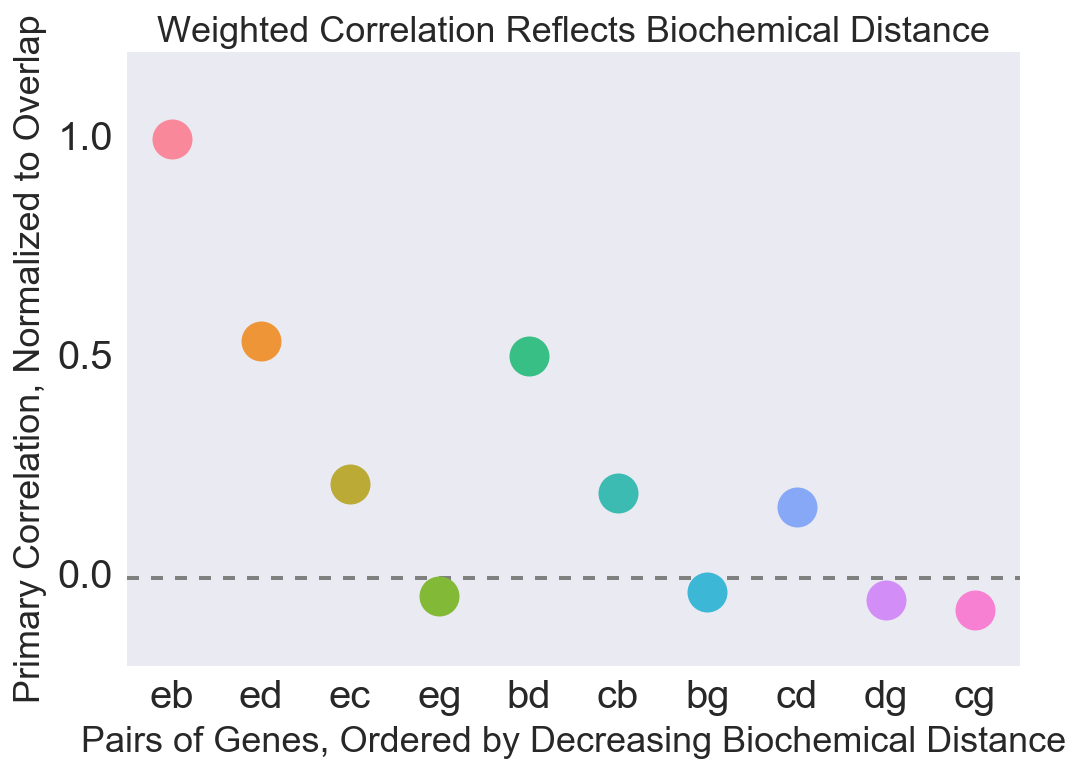

In [392]:
sort_pairs = {'eb': 1,
              'ed': 2,
              'ec': 3,
              'eg': 4,
              'bd': 5,
              'cb': 6,
              'bg': 7,
              'cd': 8,
              'dg': 9,
              'cg': 10
             }
def sorted_pairs(x):
    key = x.pair
    if key in sort_pairs.keys():
        return sort_pairs[key]
    else:
        return np.nan

d['sort_pairs'] = d.apply(sorted_pairs, axis=1)
# d.head()
d.sort('sort_pairs', inplace=True)
sns.stripplot(x='pair', y='weighted_primary_corr', data=d[d.regression=='primary'], size=20)
plt.xticks(fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.xlabel('Pairs of Genes, Ordered by Decreasing Biochemical Distance')
plt.ylabel('Primary Correlation, Normalized to Overlap')
plt.title('Weighted Correlation Reflects Biochemical Distance')
plt.savefig('../output/weighted_corr_decreases_w_distance.pdf')

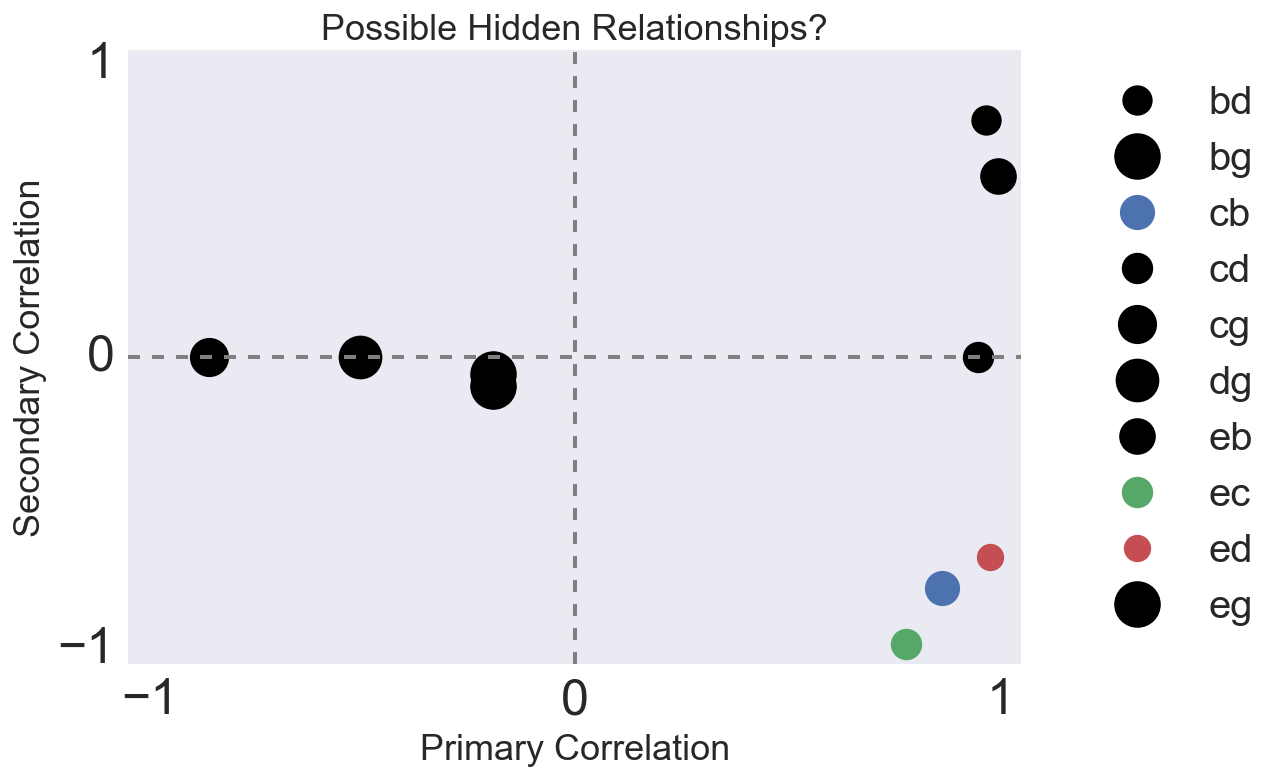

In [407]:
d.sort_values('pair', inplace=True)
size = 20*np.linspace(0.5, 1, len(d.pair))
color = ['#B0171F','#DA70D6','#FF00FF','#7A378B', '#7D26CD','#0000FF', '#1E90FF','#2E8B57', '#808000', '#CD8500']

fig, ax = plt.subplots()
kp = 0
ks = 0
for i, pair in enumerate(d.pair.unique()):
    x = d[(d.pair == pair) & (d.regression == 'primary')].value
    y = d[(d.pair == pair) & (d.regression == 'secondary')].value
    fraction = d[(d.pair == pair) & (d.regression == 'secondary')].fraction_outliers.values[0]
    if np.isnan(fraction):
        fraction = d[(d.pair == pair) & (d.regression == 'primary')].fraction_outliers.values[0]
        
    if np.isnan(fraction):
        continue
    
    size = 40*np.sqrt(fraction)
    if x.values[0]*y.values[0] > -.05:
        plt.plot(x, y, 'ko', ms=size, label=pair)
    else:
        plt.plot(x, y, 'o', ms=size, label=pair)

    
plt.gca().axhline(0, ls='--', color='grey', lw=2)
plt.gca().axvline(0, ls='--', color='grey', lw=2)
plt.xticks([-1, 0, 1], fontsize=25)
# labels = ['Primary\nRegression', 'Secondary\nRegression']
# ax.set_xticklabels(labels)
plt.yticks([-1, 0, 1], fontsize=25)
plt.ylim(-1.05, 1.05)
plt.xlim(-1.05, 1.05)
plt.xlabel('Primary Correlation')
plt.legend(fontsize=20, bbox_to_anchor=(1.3, 1))
plt.ylabel('Secondary Correlation')
plt.title('Possible Hidden Relationships?')
plt.savefig('../output/huh.pdf')

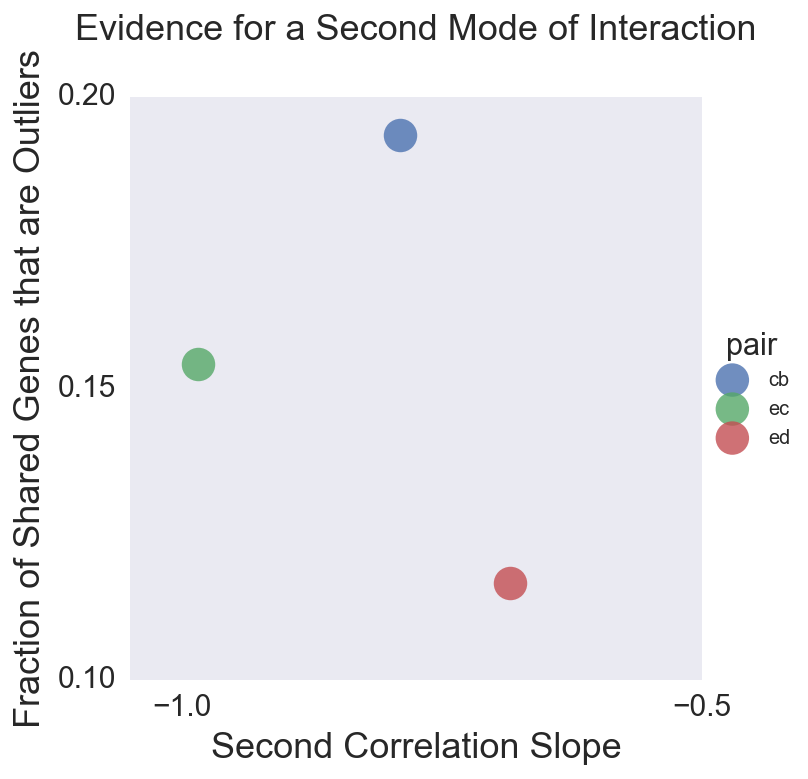

In [404]:
to_plot = d.pair.isin(['cb','ec','ed'])
sns.lmplot(x='value', y='fraction_outliers', hue='pair', data=d[(to_plot) & (d.regression == 'secondary')],
           scatter_kws={'s': 280}, fit_reg=False)
# plt.ylim(0)
# plt.xlim(-1, -0.5)
plt.xticks([-1, -0.5], fontsize=15)
plt.yticks([.10, .15, .20], fontsize=15)
plt.xlabel('Second Correlation Slope')
plt.ylabel('Fraction of Shared Genes that are Outliers')
plt.title('Evidence for a Second Mode of Interaction', y=1.08)

It appears that 'C' and 'B' and 'C' and 'E' interact in both a positive and negative manner and both correlations are well supported by evidence. Intriguing!

# Double Mutant Analysis

With double mutants, the analysis gets slightly more complicated. Now we're getting into full pathways!

A first approach is to inspect the double mutants by Spearman correlation analysis to the single mutants that make them up. A quick visualization will show us any epistasis and the extent of it:

In [ ]:
rho_matrix_doubles = genpy.double_mutant_corr_analysis(thomas.double_muts, thomas.beta_filtered)


# tri_plot(rho_matrix_doubles, ['b', 'd','b','c'], ['a', 'f'])
xticklabels = []
yticklabels = []
for key in double_mutants:
    xticklabels += double_mutants[key]
    yticklabels += key
sns.heatmap(rho_matrix_doubles, xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis')


In [ ]:
res_dict_double = genpy.double_mutant_analysis(double_mutants, beta_filtered)

In [ ]:
for key in res_dict_double:
    print(key, res_dict_double[key])

In [313]:
for key, value in thomas.double_muts.items():
    x = thomas.beta_filtered[key]
    y = thomas.beta_filtered[value[0]]
    z = thomas.beta_filtered[value[1]]
    
    x = x[x.qval < q]
    y = y[y.qval < q]
    z = z[z.qval < q]
    
    yANDz = len(y[y.target_id.isin(z)])
    yORz = len(y) + len(z)
    expected = yORz - yANDz
    
    pred1 = x[(x.target_id.isin(z.target_id))]
    pred2 = x[x.target_id.isin(y.target_id)]
    
    pred = len(list(set(pred1.target_id.tolist() + pred2.target_id.tolist())))
    
    print('Expected: ', expected)
    print('Observed: ', len(x))
    print('Predicted: ', pred)
    print('Observed/Expected: {0:.2g}'.format(len(x)/expected))
    print('Predicted/Expected: {0:.2g}'.format(pred/expected))
    print('Surprise factor: {0:.2g}'.format(pred/len(x)))

Expected:  2711
Observed:  363
Predicted:  247
Observed/Expected: 0.13
Predicted/Expected: 0.091
Surprise factor: 0.68
Expected:  2749
Observed:  2789
Predicted:  1623
Observed/Expected: 1
Predicted/Expected: 0.59
Surprise factor: 0.58


In [302]:
def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

double_mat = np.zeros(shape=(2, 5))
l = 0
cols = []
size = []
for key in thomas.double_muts:
    m = 0
    cols += [key]
    for j in thomas.single_mutants:
        x = thomas.beta_filtered[key]
        y = thomas.beta_filtered[j]
        
        ovx = x[lind(x)]
        L = len(ovx)  # length of the double mutant transcriptome
        ovy = y[lind(y) & y.target_id.isin(ovx.target_id)].copy()
        ovx = x[lind(x) & x.target_id.isin(ovy.target_id)].copy()
        
        ovx = find_rank(ovx)
        ovy = find_rank(ovy)
        
        size += [len(ovx)]  # size of the overlap between double and single
        print('\n{0} - {1}\nObserved: {2},\nOverlap: {3}'.format(thomas.double_muts[key], j, L, len(ovx)))
        mean_slope = stats.spearmanr(ovx.b, ovy.b)[0]
        # Set up MCMC parameters
        data = dict(x=ovx.r, y=ovy.r)
        trace = robust_regress(data)
        mean_slope = trace.x.mean()
        print('\n{0:.2g}'.format(mean_slope))
        double_mat[l, m] = mean_slope
        m += 1
    l += 1

bc - g
Observed: 363,
Overlap: 63
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec
-0.017
bc - d
Observed: 363,
Overlap: 167
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec
0.9
bc - b
Observed: 363,
Overlap: 210
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.5 sec
0.94
bc - c
Observed: 363,
Overlap: 101
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.7 sec
0.94
bc - e
Observed: 363,
Overlap: 255
Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec
0.94
bd - g
Observed: 2789,
Overlap: 494
Applied log-transform to lam and added 

Double mutants:
$$
a = b^-d^-
$$

$$
f = b^-c^-
$$

In [305]:
double_corr = pd.DataFrame(double_mat.transpose(), columns=cols)
double_corr = pd.melt(double_corr, var_name='double_mutant', value_name='correlation')
double_corr['corr_var'] = thomas.single_mutants*2

# correct the correlations by the average size of the pool that was used for 
double_corr['s'] = size

def weighted_corr(x):
    m = len(thomas.beta_filtered[x.double_mutant])
    
    return x.correlation*x.s/double_corr.s.max()

# weight the correlation by the size of the group that was compared, then normalize to one by dividing by the max
double_corr['weighted_corr'] = double_corr.apply(weighted_corr, 
                                                 axis=1)
double_corr

,double_mutant,correlation,corr_var,s,weighted_corr
0,f,-0.016975,g,63,-0.000708
1,f,0.901857,d,167,0.099742
2,f,0.940540,b,210,0.130804
3,f,0.940891,c,101,0.062934
4,f,0.939247,e,255,0.158614
5,a,-0.114356,g,494,-0.037412
6,a,0.981307,d,784,0.509500
7,a,0.975539,b,1468,0.948405
8,a,0.505294,c,463,0.154934
9,a,0.985358,e,1510,0.985358


f bc
a bd


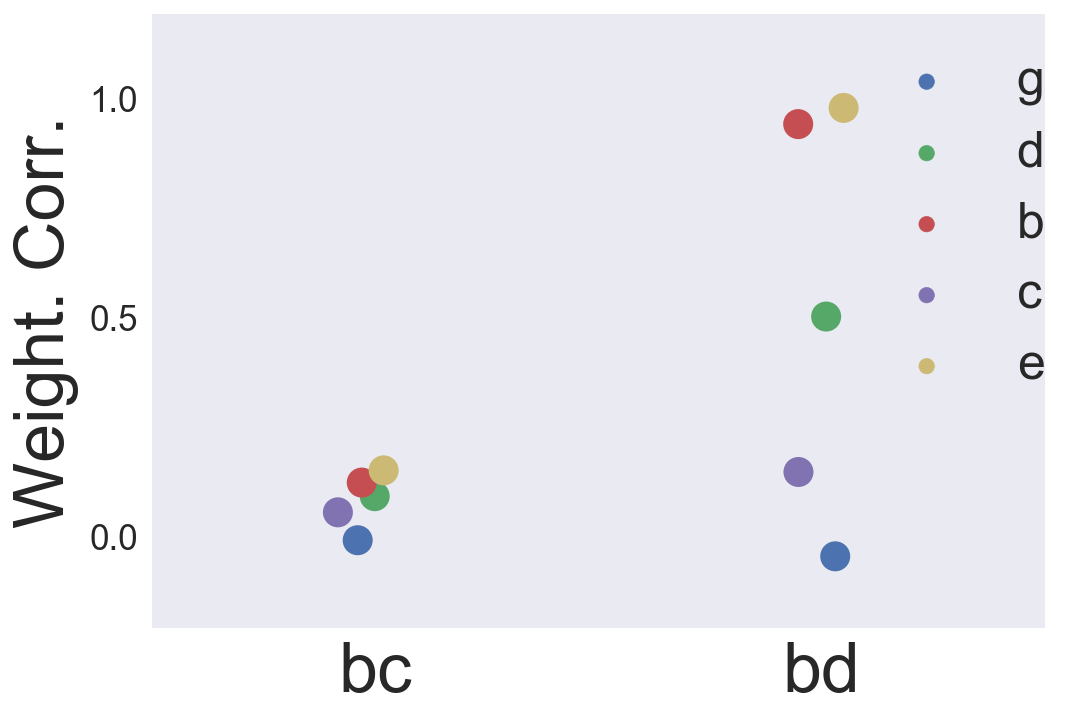

In [306]:
# /double_corr.apply(weighted_corr, axis=1).max()
sns.stripplot(x='double_mutant', y='weighted_corr', hue='corr_var', data=double_corr, size=15, jitter=True)
plt.legend(bbox_to_anchor= (1.05, 1), fontsize=25)

ax = plt.gca()

xlabels = []
for c in double_corr.double_mutant.unique():
    print(c, thomas.double_muts[c])
    xlabels += [thomas.double_muts[c]]

# x = np.linspace(0, len(ax.get_xticklabels())-1, len(ax.get_xticklabels()))
# plt.xlabels(fontsize=20*ft)
plt.yticks([0, 0.5, 1], fontsize=ft/2)
plt.ylabel('Weight. Corr.', fontsize=35)
plt.gca().set_xticklabels(xlabels, fontsize=ft)
plt.xlabel('')
# plt.title('Double Mutants Have Additive and Epistatic Effects ')
plt.savefig('../output/epistasis_spearmanr.pdf')

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.4 secApplied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.4 sec

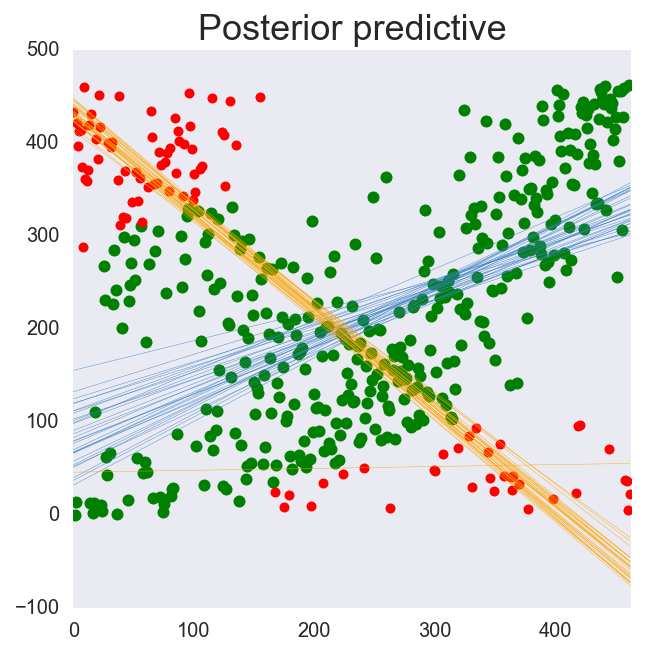

In [207]:
letters = ['a', 'c']

x = thomas.beta_filtered[letters[0]]
y = thomas.beta_filtered[letters[1]]

ovx = x[lind(x)]
ovy = y[lind(y) & y[genes].isin(ovx[genes])].copy()
ovx = x[lind(x) & x[genes].isin(ovy[genes])].copy()

xns = x[~x.target_id.isin(ovx.target_id)].copy()
yns = y[~y.target_id.isin(ovx.target_id)].copy()

def find_rank(df):
    """A function to find the rank values of a variable."""
    d = df.copy()
    d.sort_values('b', inplace=True)
    rank = np.linspace(0, len(d)-1, len(d))
    d['r'] = rank
    d.sort_values('target_id', inplace=True)
    return d

ovx = find_rank(ovx)
ovy = find_rank(ovy)

data = dict(x=ovx.r, y=ovy.r)

x = np.linspace(ovx.r.min(), ovx.r.max())
    
trace_robust = robust_regress(data)
plt.figure(figsize=(5, 5))

distribution =ovy.r - trace_robust.Intercept.mean() - ovx.r*trace_robust.x.mean()
mean = distribution.mean()
std = distribution.std()
distribution_inliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) < 1]
distribution_outliers = distribution[np.abs(distribution - mean)/(trace_robust.x.std() 
                                                                 + trace_robust.Intercept.std()+ std) > 1]

outliers = ovy[ovy.r.isin(distribution_outliers + 
                          trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean())].target_id

data2 = dict(x=ovx[ovx.target_id.isin(outliers)].r, y=ovy[ovy.target_id.isin(outliers)].r)
trace_robust2 = robust_regress(data2)


yri = distribution_inliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()
yro = distribution_outliers + trace_robust.Intercept.mean() + ovx.r*trace_robust.x.mean()

plt.plot(ovx.r, yri, 'go', ms = 6)
plt.plot(ovx.r, yro, 'ro', ms = 5)
pm.glm.plot_posterior_predictive(trace_robust, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#357EC7')
pm.glm.plot_posterior_predictive(trace_robust2, eval=x, 
                                 label='posterior predictive regression lines',
                                 color='#FFA500')
plt.xlim(0, len(ovx))
# plt.legend()

if np.abs(trace_robust.x.mean()) > 0.6 and np.abs(trace_robust2.x.mean()) > 0.6:
    t1 = trace_robust.x.mean()/np.abs(trace_robust.x.mean())
    t2 = trace_robust2.x.mean()/np.abs(trace_robust2.x.mean())
    if t1 == -t2:
        print('Complex Regulation at Work')

# Defining the Hypoxia Response

In [88]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)

# make sure they all go in the same direction:
ind4 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)

hypoxia_genes = ovb[ind1 & ind2 & ind3 & ind4].copy()

In [89]:
len(hypoxia_genes)

542

In [ ]:
tissue_df = tea.fetch_dictionary()
df_res, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene, tissue_df, save=False)

In [278]:
hypoxia_genes['avg_qval'] = (hypoxia_genes.qval + hypoxia_genes.e_qval + hypoxia_genes.d_qval)/3
hypoxia_genes['avg_b'] = (hypoxia_genes.b + hypoxia_genes.d_b + hypoxia_genes.e_b)/3
hypoxia_genes.sort_values(['avg_qval'], inplace=True)
hypoxia_genes.to_csv('../output/hypoxia_high_confidence.csv', index=False)

# The genes upregulated by egl-9 should be down in Hif-1.

However, egl-9 and hif-1 seem to have a positive primary relationship under normoxic conditions. Are the secondary genes associated with the hypoxia response?

In [148]:
# First, identify the genes that are outliers in the bc, ec response and intersect them.
bc_in = thomas.correlated_genes['b', 'c']['corr']
ec_in = thomas.correlated_genes['c', 'e']['corr']
bec_in = np.intersect1d(bc_in, ec_in)
print("""
There are {0} genes that are outliers in the BC intersection,
There are {1} genes that are outliers in the EC intersection,
and there are {2} genes in the BEC outlier intersection.
""".format(len(bc_in), len(ec_in), len(bec_in)))


bc = thomas.correlated_genes['b', 'c']['outliers']
ec = thomas.correlated_genes['c', 'e']['outliers']

bec = np.intersect1d(bc, ec)
print("""
There are {0} genes that are outliers in the BC intersection,
There are {1} genes that are outliers in the EC intersection,
and there are {2} genes in the BEC outlier intersection.
""".format(len(bc), len(ec), len(bec)))

print(
"""
{0:.2g} of the genes in the BEC intersection are outliers
""".format(len(bec)/(len(bec) + len(bec_in)))
)


There are 246 genes that are outliers in the BC intersection,
There are 302 genes that are outliers in the EC intersection,
and there are 170 genes in the BEC outlier intersection.


There are 59 genes that are outliers in the BC intersection,
There are 55 genes that are outliers in the EC intersection,
and there are 23 genes in the BEC outlier intersection.


0.12 of the genes in the BEC intersection are outliers



In [433]:
intersection = hypoxia_genes[hypoxia_genes.target_id.isin(bec)].target_id.unique()
print(
"""
There are {} genes from the BEC intersection in the hypoxia set!
""".format(len(intersection))
)



There are 9 genes from the BEC intersection in the hypoxia set!



In [434]:
q = 0.1
L = thomas.beta_filtered['a'].shape[0] # total genes measured for any experiment

p = stats.hypergeom.sf(len(intersection), L, len(bec), len(hypoxia_genes))

if p < 10**-3:
    print(
"""
This result is statistically significant, with p-value = {0:.2g}
""".format(p)
    )


This result is statistically significant, with p-value = 1.2e-08



In fact, it does seem that hypoxia related genes are under control of *hif-1* under normoxic conditions, and that knocking *hif-1* out in a normoxic animal causes changes in this gene set. However, this is not the PRIMARY role of *hif-1* under physiologic conditions

In [177]:
intersection.ext_gene.values

array(['dod-24', 'D1086.3', 'F09C8.1', 'fat-7', 'pud-3', 'R08E5.3',
       'pck-1', 'Y37A1B.5', 'nit-1'], dtype=object)

In [188]:
temp = thomas.beta_filtered['c']
temp[temp.target_id.isin(intersection.target_id)].qval

1822     1.915972e-04
2857     4.302364e-10
3290     3.961768e-05
3369     2.405952e-02
3646     2.975996e-02
7724     5.174896e-06
9680     5.326034e-03
10290    5.021012e-02
12305    3.382678e-02
Name: qval, dtype: float64

Unfortunately, none of them are immediately associated with the hypoxia pathway, but a number of these are stress response genes! Thankfully, the q-values are also reasonably low for most of these genes. We're all good. 

# Tissue and Phenotype Enrichment Analyses:

In [ ]:
thomas.enrichment_analysis(x='ens_gene', analysis='tissue')

In [ ]:
df_phe, unused = tea.enrichment_analysis(hypoxia_genes.ens_gene.unique(), phenotype_df, show=False, save=False)
df_phe.head()

# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [419]:
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv', sep=',')

In [ ]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS, col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0], ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        nhr57 = np.exp(found[found.ens_gene == 'WBGene00003647'].b.values[0])
        print('nhr-57 is in', sm, 'and its fold change was {0:.2g}'.format(nhr57))
    
    print('----------')

In [ ]:
# hypoxia_genes.to_csv('../hypoxia_genes.csv',index=False)
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.core.display import HTML

# Use Bokeh chart to make plot
hypoxia_genes['logq'] = -np.log(hypoxia_genes.avg_qval)
hypoxia_genes['logq'] = hypoxia_genes['logq'].astype(np.float64)
hypoxia_genes['avg_b'].astype(np.float64)
hypoxia_genes.logq.fillna(700, inplace=True)
hypoxia_genes.logq.replace([np.inf], 700, inplace=True)
hypoxia_genes.logq.replace([-np.inf], 0, inplace=True)

hypoxia_genes.b.replace([np.inf], 6, inplace=True)
hypoxia_genes.b.replace([-np.inf], -6, inplace=True)
hypoxia_genes.dropna(inplace=True)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label ='b'
p.yaxis.axis_label ='-log(Q)'

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
source1 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b < 0])
source2 = bokeh.models.ColumnDataSource(hypoxia_genes[hypoxia_genes.avg_b > 0])
# Specify data source
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source1, color='blue')
p.circle(x='avg_b', y='logq', size=7, alpha=0.2, source=source2, color='red')
p.legend.background_fill_alpha = 0.25
p.legend.background_fill_color = 'blanchedalmond'
html = file_html(p, CDN, "my plot")
HTML(html)

vhl-1 fog-2
egl-9 fog-2
egl-9 vhl-1
hif-1 fog-2
hif-1 vhl-1
hif-1 egl-9
rhy-1 fog-2
rhy-1 vhl-1
rhy-1 egl-9
rhy-1 hif-1


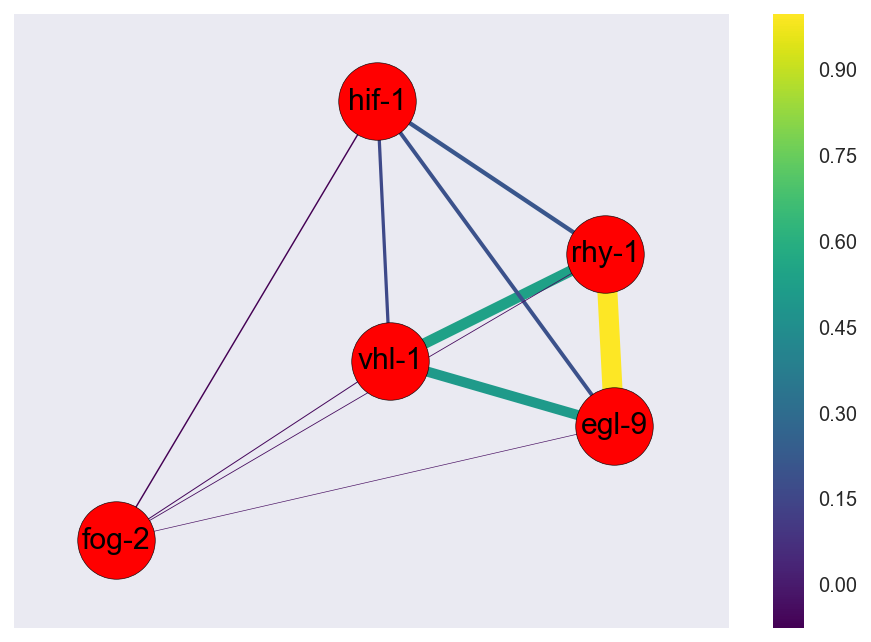

In [462]:
G=nx.Graph()

mutant_dict = {'b': 'egl-9',
               'c': 'hif-1',
               'e': 'rhy-1',
               'd': 'vhl-1',
               'g': 'fog-2'
              }

# for i in single_mutants:
#     G.add_node(i)

for i, key in enumerate(thomas.single_mutants):
    for j, key2 in enumerate(thomas.single_mutants):
        df = d
        r = d[(d.variable == key) & (d.corr_with == key2) &
              (d.regression == 'primary')].weighted_primary_corr.values
        if r:
            G.add_edge(mutant_dict[key], mutant_dict[key2], weight=r[0])
            print(mutant_dict[key], mutant_dict[key2])


elarge=[(u,v) for (u,v,d) in G.edges(data=True)]
width=[10*d['weight'] for (u,v,d) in G.edges(data=True)]
weights=[d['weight'] for (u,v,d) in G.edges(data=True)]
# edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

fig, ax = plt.subplots()

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1500)

# edges
edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=width, edge_color=weights,
                       edge_cmap=plt.cm.viridis)
# edges = nx.draw_networkx_edges(G, pos, edgelist=elarge,
#                        width=width)

# labels
nx.draw_networkx_labels(G, pos, font_size=15, font_family='sans-serif')

fig.colorbar(edges)

# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig("../output/weighted_graph.pdf") # save as png
plt.show() # display

# An *in silico* qPCR experiment:

In [409]:
x = ['WBGene00001851',
     'WBGene00012324',
     'WBGene00001178',
     'WBGene00006922']

# run the experiment!
for genotype, df in thomas.beta_filtered.items():
    for xi in x:
        dfsig = df[df.qval < q]
        if xi in dfsig.ens_gene.unique():
            if genotype in ['b', 'd', 'e']:
                print('hypoxia: ', dfsig[dfsig.ens_gene == xi].ext_gene.values[0],
                      dfsig[dfsig.ens_gene == xi].b.values)
            elif genotype in ['c']:
                print('no hypoxia: ', dfsig[dfsig.ens_gene == xi].ext_gene.values[0],
                      dfsig[dfsig.ens_gene == xi].b.values)

hypoxia:  rhy-1 [ 1.36599195]
hypoxia:  egl-9 [ 1.16888823]
no hypoxia:  hif-1 [-1.55062087 -2.26086652]
no hypoxia:  rhy-1 [ 0.45834872]
hypoxia:  rhy-1 [ 2.52830236]
hypoxia:  egl-9 [ 1.32586701]
hypoxia:  rhy-1 [ 1.49533234]
hypoxia:  egl-9 [ 0.81007544]


In [411]:
# Test with the Double Mutant:

# Predict: bd mutant should have rhy-1 UP and egl-9 UP,
# with rhy-1 fold change > egl-9 fold change
# run the experiment!
for genotype, df in thomas.beta_filtered.items():
    for xi in x:
        dfsig = df[df.qval < q]
        if xi in dfsig.ens_gene.unique():
            if genotype in ['a']:
                print('hypoxia: ', dfsig[dfsig.ens_gene == xi].ext_gene.values[0],
                      dfsig[dfsig.ens_gene == xi].b.values)
            elif genotype in ['f']:
                print('no hypoxia: ', dfsig[dfsig.ens_gene == xi].ext_gene.values[0],
                      dfsig[dfsig.ens_gene == xi].b.values)

no hypoxia:  hif-1 [-1.79148942 -2.70742154]
no hypoxia:  rhy-1 [ 0.41394473]
hypoxia:  rhy-1 [ 2.58536913]
hypoxia:  egl-9 [ 1.61137008]


# Define the Absolute Gold Set 
by Finding the Intersection Between the Double Mutant that is Constitutively Hypoxic and the single mutants that are also hypoxic

In [267]:
temp = thomas.beta_filtered['a']
temp = temp[temp.qval < q]
temp = temp[temp.target_id.isin(hypoxia_genes.target_id)]

In [280]:
temp['b_sm'] = hypoxia_genes.b
temp['qval_avg_sm'] = hypoxia_genes.avg_qval
temp['avg_b_sm'] = hypoxia_genes.avg_b

gold = temp[temp.b*temp.b_sm > 0]

In [281]:
gold.head()

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,b_sm,qval_avg_sm,avg_b_sm
77,2189,B0205.11,1.197936e-03,1.011487e-02,-0.293363,0.090562,5.537161,0.035222,0.004145,0.007610,0.008157,0.008157,WBGene00015025,mrpl-9,-0.345981,0.009488,-0.386837
82,762,B0205.7,5.988900e-08,1.452662e-06,-0.309054,0.057030,7.116642,0.029773,0.000860,0.000539,0.004019,0.004019,WBGene00002191,kin-3,-0.241362,0.011787,-0.262453
90,207,B0213.14,5.350072e-20,4.777071e-18,-0.974203,0.106392,5.458336,0.298304,0.004436,0.012543,0.008620,0.012543,WBGene00015043,cyp-34A8,-0.742839,0.002248,-0.544331
96,475,B0218.6a,9.691039e-11,3.770936e-09,-1.062462,0.164171,5.526455,0.342259,0.032211,-0.027697,0.008217,0.008217,WBGene00015050,clec-51,-0.846454,0.014495,-0.524852
97,2,B0218.8,0.000000e+00,0.000000e+00,3.451984,0.077133,6.622435,3.581997,0.003766,0.005158,0.004594,0.005158,WBGene00015052,clec-52,3.330682,0.000003,2.182973


In [425]:
ind = (genpy.find(hypoxia_genes, hypoxia_gold.WBIDS, col='ens_gene'))
found = hypoxia_genes[ind].ens_gene.unique()
sig = len(hypoxia_genes)
pval = stats.hypergeom.sf(len(found), len(thomas.beta_filtered['a']), len(hypoxia_gold), sig)    
    


In [426]:
pval

1.5931004612170831e-05

In [435]:
hypoxia_genes[ind].ext_gene.unique()

array(['rhy-1', 'nhr-57', 'phy-2', 'oac-54', 'cysl-2', 'egl-9'], dtype=object)

In [437]:
for key, df in thomas.beta_filtered.items():
    x = df[df.qval<q]
    print(key, x[x.b > 0].shape[0], x[x.b < 0].shape[0])

f 223 140
d 524 445
a 1488 1301
c 497 434
b 926 854
e 1198 1226
g 731 874


In [438]:
len(gold)

519

In [479]:
gold[gold.target_id.isin(tf_df.target_id)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,b_sm,qval_avg_sm,avg_b_sm
514,182,C02F12.5,1.271031e-22,1.290795e-20,1.863251,0.190366,5.129345,1.084998,0.009851,0.044507,0.011278,0.044507,WBGene00015355,C02F12.5,1.567721,1.026012e-02,1.253357
3699,1926,F17C11.1,4.779374e-04,4.586561e-03,0.753843,0.215826,3.861786,0.191491,0.020659,0.005600,0.049213,0.049213,WBGene00008913,F17C11.1,0.865792,1.272271e-02,0.796695
8296,5,T05B4.2,1.299800e-238,4.804840e-235,4.118097,0.124845,6.131072,5.106320,0.009241,0.014138,0.005604,0.014138,WBGene00003647,nhr-57,4.144197,6.147653e-43,3.314348
9206,440,T24C4.7,3.125001e-11,1.312713e-09,0.376368,0.056677,7.168280,0.043267,0.000841,0.000124,0.003977,0.003977,WBGene00020763,ztf-18,0.219505,7.487412e-03,0.240118
9441,2838,VC5.5,6.251414e-03,4.071349e-02,0.592599,0.216728,3.858436,0.147388,0.021008,0.031536,0.049449,0.049449,WBGene00003725,nhr-135,0.674766,1.277311e-02,0.785916
9543,447,W02D7.6,4.108610e-11,1.698869e-09,0.503893,0.076346,5.992265,0.080508,0.002697,0.002722,0.006046,0.006046,WBGene00020942,W02D7.6,0.349855,3.196347e-03,0.331905


# Hypoxia Positive Interaction

In [513]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ovd = thomas.beta_filtered['d']
ove = thomas.beta_filtered['e']
ovc = thomas.beta_filtered['c']
ova = thomas.beta_filtered['a']

ovb['d_qval'] = ovd.qval
ovb['e_qval'] = ove.qval
ovb['c_qval'] = ovc.qval
# ovb['a_qval'] = ova.qval

ovb['d_b'] = ovd.b
ovb['e_b'] = ove.b
ovb['c_b'] = ovc.b
# ovb['a_b'] = ova.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
# ind2 = (ovb.d_qval < 0.1)
ind3 = (ovb.e_qval < 0.1)
ind4 = (ovb.c_qval < 0.1)
# ind5 = (ovb.a_qval < 0.1)

i1 = ind1 & ind2 & ind3 & ind4 #& ind5

# make sure they all go in the same direction:
# ind5 = (ovb.b*ovb.d_b > 0) & (ovb.b*ovb.e_b > 0) & (ovb.d_b*ovb.e_b >0)
# ind6 = (ovb.b*ovb.c_b > 0) & (ovb.c_b*ovb.e_b > 0) & (ovb.d_b*ovb.c_b >0)

ind5 =  (ovb.b*ovb.e_b > 0)
ind6 = (ovb.b*ovb.c_b > 0) & (ovb.c_b*ovb.e_b > 0)
# ind7 = (ovb.b*ovb.a_b > 0) & (ovb.c_b*ovb.a_b > 0) & (ovb.e_b*ovb.a_b > 0)

i2 = ind5 & ind6 #& ind7

# novel_response = ovb[ind1 & ind2 & ind3 & ind4 & ind5 & ind6].copy()
novel_response = ovb[i1 & i2].copy()


novel_response['avg_qval'] = (ovb.qval + ovb.d_qval + ovb.e_qval + ovb.c_qval)/4
novel_response['avg_b'] = (ovb.b + ovb.d_b + ovb.e_b + ovb.c_b)/4
novel_response.sort_values(['avg_qval'], inplace=True)

In [517]:
len(novel_response.ens_gene.unique())

92

# Searching for a TF that is activated by both egl-9 and hif-1
And possibly regulates rhy-1 as a result

In [484]:
# Figure out how many hits we get and if the pvalue is significant!
tfs = {}
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, tf_df.target_id, col='target_id'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = stats.hypergeom.sf(len(found), len(df), len(hypoxia_gold), len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), '      Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    tfs[sm] = found.copy()
        
    print('----------')

genotype:  g
found:  33       Mean b: 0.13
pval: 0
----------
genotype:  d
found:  15       Mean b: 0.53
pval: 1.4e-14
----------
genotype:  b
found:  18       Mean b: 0.59
pval: 7.2e-15
----------
genotype:  c
found:  23       Mean b: 0.03
pval: 0
----------
genotype:  e
found:  34       Mean b: 0.49
pval: 0
----------


In [487]:
tfs['b'][tfs['b'].target_id.isin(tfs['c'].target_id)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene
2910,1378,D2030.7,7.776407e-04,0.010505,0.216208,0.064336,7.616766,0.018991,0.000473,0.005735,0.005513,0.005735,WBGene00008417,D2030.7
5295,538,F46G10.6,1.005785e-07,0.000003,-0.770323,0.144643,4.762991,0.202726,0.010022,0.020861,0.021361,0.021361,WBGene00003511,mxl-3


In [494]:
tfs['c'][tfs['c'].target_id.isin(tfs['b'].target_id)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene
2910,877,D2030.7,3.363298e-03,7.038140e-02,-0.194831,0.066440,7.446829,0.016685,0.000613,0.006009,0.005036,0.006009,WBGene00008417,D2030.7
5295,59,F46G10.6,2.257550e-11,6.993926e-09,-0.920322,0.137601,4.723483,0.259740,0.010014,-0.002961,0.018387,0.018387,WBGene00003511,mxl-3


In [495]:
tfs['e'][tfs['e'].target_id.isin(tfs['c'].target_id)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene
2910,1827,D2030.7,0.000972,0.010094,0.196333,0.059524,7.704062,0.014532,0.000464,0.003247,0.004851,0.004851,WBGene00008417,D2030.7
4780,2055,F38A5.13,0.002155,0.019901,-0.199605,0.065061,7.429869,0.017032,0.000594,0.005755,0.004957,0.005755,WBGene00001029,dnj-11
5295,2283,F46G10.6,0.003817,0.031712,-0.329363,0.113853,5.080461,0.038886,0.006009,0.001919,0.013435,0.013435,WBGene00003511,mxl-3
9165,1074,T23G5.6,0.000016,0.000285,1.074609,0.249168,4.383067,0.420937,0.016543,0.076585,0.024564,0.076585,WBGene00011964,saeg-2


In [493]:
temp = thomas.beta_filtered['f']
temp[(temp.target_id.isin(tf_df.target_id)) & (temp.qval < 0.1)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene
2355,326,C46F11.3,0.001129,0.063375,0.292814,0.089923,5.960578,0.028724,0.002544,0.001209,0.009586,0.009586,WBGene00008118,madf-8
2910,311,D2030.7,0.000963,0.056700,0.300176,0.090932,7.701105,0.036954,0.000422,0.011981,0.008521,0.011981,WBGene00008417,D2030.7
4671,190,F35H8.3,0.000177,0.017127,0.300030,0.080012,6.749631,0.031972,0.001273,0.004935,0.008330,0.008330,WBGene00009448,zfp-2
5295,373,F46G10.6,0.001698,0.083105,-0.734850,0.234141,4.822973,0.227788,0.008866,0.073367,0.017914,0.073367,WBGene00003511,mxl-3
9206,82,T24C4.7,0.000003,0.000664,0.363227,0.077739,7.168336,0.046036,0.000824,0.007245,0.008241,0.008241,WBGene00020763,ztf-18
11228,248,Y54E10BR.8,0.000430,0.031736,0.288798,0.082023,6.419975,0.025848,0.001493,-0.000459,0.008599,0.008599,WBGene00021846,ztf-23


In [523]:
temp = thomas.beta_filtered['a']
temp[(temp.target_id.isin(tf_df.target_id)) & (temp.qval < 0.1)]
temp[(temp.ext_gene == 'mxl-3') & (temp.qval < 0.1)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene
5295,2942,F46G10.6,0.007859,0.049374,-0.294871,0.110934,5.036353,0.039349,0.006108,0.010473,0.012352,0.012352,WBGene00003511,mxl-3


# Looking for a factor that regulates rhy-1 and is NOT a TF

In [543]:
# find all the genes in the hypoxia response:
ovb = thomas.beta_filtered['b'].copy()
ove = thomas.beta_filtered['e']
ovc = thomas.beta_filtered['c']

ovb['e_qval'] = ove.qval
ovb['c_qval'] = ovc.qval
# ovb['a_qval'] = ova.qval

ovb['e_b'] = ove.b
ovb['c_b'] = ovc.b
# ovb['a_b'] = ova.b

# qvalue cutoff
ind1 = (ovb.qval < 0.1)
ind3 = (ovb.e_qval < 0.1)
ind4 = (ovb.c_qval < 0.1)

i1 = ind1 & ind2 & ind3 & ind4 #& ind5

# make sure they all go in the same direction:
ind = (ovb.c_b < 0) & (ovb.b > 0) & (ovb.e_b > 0)

i2 = ind

# novel_response = ovb[ind1 & ind2 & ind3 & ind4 & ind5 & ind6].copy()
rhy1regs = ovb[i1 & i2].copy()


rhy1regs['avg_qval'] = (ovb.qval +  ovb.e_qval + ovb.c_qval)/3
rhy1regs['avg_b'] = (ovb.b + ovb.e_b + ovb.c_b)/3
rhy1regs.sort_values(['avg_qval'], inplace=True)

In [544]:
rhy1regs.shape

(9, 20)

In [545]:
rhy1regs[~rhy1regs.target_id.isin(tf_df.target_id)]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,e_qval,c_qval,e_b,c_b,avg_qval,avg_b
7724,2,R08E5.3,0.000000e+00,0.000000e+00,4.695738,0.108571,7.668167,6.629132,0.002545,0.015136,0.005525,0.015136,WBGene00019963,R08E5.3,0.000000e+00,0.000005,4.590644,-0.689419,0.000002,2.865654
9680,4,W05G11.6c,3.107323e-187,1.446381e-183,2.763440,0.094691,7.052105,2.295452,0.007732,-0.002143,0.005717,0.005717,WBGene00021043,pck-1,9.904312e-58,0.005326,1.982641,-0.575080,0.001775,1.390334
12305,7,ZK1058.6,5.853763e-162,1.557017e-158,3.464394,0.127747,5.414238,3.609553,0.012470,-0.001289,0.012009,0.012009,WBGene00014206,nit-1,8.735406e-164,0.033827,3.380002,-1.199625,0.011276,1.881590
12567,1084,ZK546.15,1.404087e-04,2.411688e-03,0.319086,0.083806,7.331195,0.038973,0.000676,0.009859,0.005540,0.009859,WBGene00006619,try-1,5.014556e-06,0.033273,0.337269,-0.235635,0.011897,0.140240
11219,1822,Y54E10BL.4,3.660655e-03,3.740820e-02,0.243025,0.083628,6.021442,0.020886,0.002464,0.001496,0.008026,0.008026,WBGene00001046,dnj-28,2.024273e-14,0.008301,0.613958,-0.338421,0.015236,0.172854
10290,37,Y37A1B.5a,2.318797e-53,1.183172e-50,2.681384,0.174371,6.702134,2.193432,0.003123,0.042485,0.006165,0.042485,WBGene00012538,Y37A1B.5,1.807121e-47,0.050210,2.603987,-0.570032,0.016737,1.571780
1726,1541,C30B5.1,1.567269e-03,1.893640e-02,0.252573,0.079879,8.059511,0.026795,0.000302,0.009269,0.005782,0.009269,WBGene00077732,szy-4,8.714231e-05,0.034423,0.310731,-0.194278,0.017816,0.123009
3588,256,F14E5.5,1.040848e-13,7.570134e-12,1.567392,0.210795,6.168876,0.790337,0.002687,0.063965,0.007461,0.063965,WBGene00008803,lips-10,1.146043e-45,0.056799,1.636837,-0.659158,0.018933,0.848357
1465,1434,C25A1.8,9.902662e-04,1.285758e-02,0.347521,0.105524,10.226511,0.041220,0.000035,0.006201,0.016669,0.016669,WBGene00007709,clec-87,3.279330e-03,0.069842,0.286490,-0.234316,0.028660,0.133232
